<a href="https://colab.research.google.com/github/irenetesalonikapanjaitan/ATS_Irene_Tesalonika/blob/main/ATS_Irene_Tesalonika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

try:
    import cupy as cp
    import cudf
    from cuml.svm import SVC as cuSVC
    from cuml.model_selection import train_test_split as cu_train_test_split
    gpu_available = True
except Exception as e:
    gpu_available = False

print("✓ Libraries diimport.")

✓ Libraries diimport.


In [5]:
dataset_dir = Path("/content/drive/MyDrive/ATS_Irene_Tesalonika/Dataset")
train_csv_file = dataset_dir / "emnist-letters-train.csv"
mapping_text_file = dataset_dir / "emnist-letters-mapping.txt"

def check_file_exists(file_path: Path, file_type: str):
    if not file_path.is_file():
        raise FileNotFoundError(f"Error: {file_type} tidak ditemukan di path: {file_path}")
    return True

check_file_exists(train_csv_file, "File dataset")
check_file_exists(mapping_text_file, "File mapping")

print(f"Dataset : {train_csv_file}")
print(f"File mapping ditemukan: {mapping_text_file}")


Dataset : /content/drive/MyDrive/ATS_Irene_Tesalonika/Dataset/emnist-letters-train.csv
File mapping ditemukan: /content/drive/MyDrive/ATS_Irene_Tesalonika/Dataset/emnist-letters-mapping.txt


In [6]:
def read_emnist_dataset(csv_file_path: Path):
    data_frame = pd.read_csv(csv_file_path, header=None)
    label_values = data_frame.iloc[:, 0].values.astype(np.int64) - 1
    image_pixels = data_frame.iloc[:, 1:].values.astype(np.uint8)
    image_array = image_pixels.reshape(-1, 28, 28)
    image_array = np.transpose(image_array, (0, 2, 1))
    image_array = np.flip(image_array, axis=2)
    return image_array, label_values

TOTAL_CLASSES = 26
SAMPLES_EACH_CLASS = 500

print("Sedang memuat dataset...")
data_images, data_labels = read_emnist_dataset(train_csv_file)
print(f"Dataset : {data_images.shape[0]} sampel")
print(f"Ukuran gambar: {data_images[0].shape}")
print(f"label: {data_labels.min()} hingga {data_labels.max()} (A-Z)")

Sedang memuat dataset...
Dataset : 88800 sampel
Ukuran gambar: (28, 28)
label: 0 hingga 25 (A-Z)


In [7]:
def build_balanced_subset(images: np.ndarray, labels: np.ndarray,
                          n_samples: int = SAMPLES_EACH_CLASS,
                          random_seed: int = 42):
    np.random.seed(random_seed)

    df = pd.DataFrame({
        'index': np.arange(len(labels)),
        'label': labels
    })

    sampled_indices = []
    for cls in range(TOTAL_CLASSES):
        class_data = df[df['label'] == cls]
        class_count = len(class_data)

        if class_count < n_samples:
            raise ValueError(f"Kelas {cls} memiliki {class_count} sampel, kurang dari {n_samples} yang dibutuhkan")

        selected = class_data.sample(n=n_samples, random_state=random_seed)
        sampled_indices.extend(selected['index'].values.tolist())

    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)

    subset_images = images[sampled_indices]
    subset_labels = labels[sampled_indices]

    return subset_images, subset_labels

print("Memproses pembuatan subset dataset seimbang...")
image_data, label_data = build_balanced_subset(data_images, data_labels)
print(f"Subset dataset: {image_data.shape[0]} sampel")
print(f"Konfigurasi: {SAMPLES_EACH_CLASS} sampel setiap kelas dari {TOTAL_CLASSES} kelas")
print(f"Total sampel: {len(image_data)} gambar, {len(label_data)} label")


Memproses pembuatan subset dataset seimbang...
Subset dataset: 13000 sampel
Konfigurasi: 500 sampel setiap kelas dari 26 kelas
Total sampel: 13000 gambar, 13000 label


In [8]:
print("\n" + "="*60)
print("INFORMASI SUBSET DATASET PER KELAS")
print("="*60)

class_info = []
for cls_id in range(TOTAL_CLASSES):
    class_mask = label_data == cls_id
    class_count = np.sum(class_mask)
    class_indices = np.where(class_mask)[0]
    class_letter = chr(cls_id + ord('A'))

    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        sample_image = image_data[sample_idx]
        image_shape = sample_image.shape
        pixel_min = sample_image.min()
        pixel_max = sample_image.max()
        pixel_mean = sample_image.mean().round(2)

        class_info.append({
            'Kelas': class_letter,
            'Jumlah_Sampel': class_count,
            'Dimensi_Gambar': f"{image_shape[0]}x{image_shape[1]}",
            'Pixel_Min': pixel_min,
            'Pixel_Max': pixel_max,
            'Pixel_Rata2': pixel_mean
        })

info_df = pd.DataFrame(class_info)
print("\nRingkasan Dataset per Kelas:")
print(info_df.to_string(index=False))

print("\n" + "="*60)
print("STATISTIK")
print("="*60)
print(f"Total sampel dalam subset: {len(image_data):,} gambar")
print(f"Jumlah kelas: {TOTAL_CLASSES} kelas (A-Z)")
print(f"Sampel per kelas: {SAMPLES_EACH_CLASS} sampel")
print(f"Dimensi gambar: {image_data[0].shape[0]}x{image_data[0].shape[1]} piksel")
print(f"Range nilai pixel: {image_data.min()} - {image_data.max()}")
print(f"Rata-rata nilai pixel: {image_data.mean():.2f}")
print("="*60)


INFORMASI SUBSET DATASET PER KELAS

Ringkasan Dataset per Kelas:
Kelas  Jumlah_Sampel Dimensi_Gambar  Pixel_Min  Pixel_Max  Pixel_Rata2
    A            500          28x28          0        255        44.20
    B            500          28x28          0        255        60.14
    C            500          28x28          0        255        31.17
    D            500          28x28          0        255        48.61
    E            500          28x28          0        255        60.95
    F            500          28x28          0        255        32.78
    G            500          28x28          0        255        69.04
    H            500          28x28          0        255        31.27
    I            500          28x28          0        255        29.43
    J            500          28x28          0        255        39.29
    K            500          28x28          0        255        43.65
    L            500          28x28          0        255        35.09
    M      

In [9]:
from skimage.feature import hog

HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
HOG_BLOCK_NORM = "L2-Hys"

def compute_hog_features(images: np.ndarray):
    """Ekstraksi fitur HOG dari setiap gambar dalam dataset."""
    feature_list = []
    for img in tqdm(images, desc="Proses ekstraksi fitur HOG"):
        hog_feat = hog(img / 255.0,
                 orientations=HOG_ORIENTATIONS,
                 pixels_per_cell=HOG_PIXELS_PER_CELL,
                 cells_per_block=HOG_CELLS_PER_BLOCK,
                 block_norm=HOG_BLOCK_NORM,
                 visualize=False,
                 feature_vector=True)
        feature_list.append(hog_feat)
    return np.asarray(feature_list, dtype=np.float32)

print("Proses ekstraksi fitur HOG dimulai...")
print(f"Konfigurasi HOG: orientations={HOG_ORIENTATIONS}, pixels_per_cell={HOG_PIXELS_PER_CELL}, cells_per_block={HOG_CELLS_PER_BLOCK}")
hog_features = compute_hog_features(image_data)
print(f"Ekstraksi fitur HOG berhasil. Shape fitur: {hog_features.shape}")
print(f"Total sampel: {hog_features.shape[0]}, Jumlah fitur: {hog_features.shape[1]}")

Proses ekstraksi fitur HOG dimulai...
Konfigurasi HOG: orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)


Proses ekstraksi fitur HOG: 100%|██████████| 13000/13000 [00:12<00:00, 1079.18it/s]

Ekstraksi fitur HOG berhasil. Shape fitur: (13000, 144)
Total sampel: 13000, Jumlah fitur: 144


In [10]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report

# Parameters
C_PARAM = 1.0
KERNEL_TYPE = 'rbf'
GAMMA_PARAM = 'auto'

print("Inisialisasi classifier SVM...")
print(f"Konfigurasi parameter: C={C_PARAM}, kernel={KERNEL_TYPE}, gamma={GAMMA_PARAM}")
print(f'\nProses evaluasi menggunakan LOOCV...')
print(f'Jumlah sampel data: {len(label_data):,}')
print(f'Jumlah fold validasi: {len(label_data):,}')

start_time = time.time()

if gpu_available:
    X_hog_cp = cp.asarray(hog_features).astype(cp.float32)
    y_cp = cp.asarray(label_data).astype(cp.int32)
    clf = cuSVC(C=C_PARAM, kernel=KERNEL_TYPE, gamma=GAMMA_PARAM)
    Xtr_cp, Xte_cp, ytr_cp, yte_cp = cu_train_test_split(X_hog_cp, y_cp, test_size=0.2, random_state=42, stratify=y_cp)
    clf.fit(Xtr_cp, ytr_cp)
    y_pred_cp = clf.predict(Xte_cp)
    y_pred = cp.asnumpy(y_pred_cp).astype(int)
    y_true = cp.asnumpy(yte_cp).astype(int)
else:
    from sklearn.svm import SVC
    svm = SVC(C=C_PARAM, kernel=KERNEL_TYPE, gamma=GAMMA_PARAM, random_state=42, cache_size=1000)
    loo = LeaveOneOut()
    y_pred = cross_val_predict(svm, hog_features, label_data, cv=loo, n_jobs=-1, verbose=2)
    y_true = label_data

training_time = time.time() - start_time

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(TOTAL_CLASSES))
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(TOTAL_CLASSES), average='macro', zero_division=0)

labels_text = [chr(i + ord('A')) for i in range(TOTAL_CLASSES)]
prec_per_class, rec_per_class, f1_per_class, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(TOTAL_CLASSES), average=None, zero_division=0)

# Print results
print(f"\nDurasi training: {training_time:.2f} detik ({training_time/60:.2f} menit)")
print(f"Jumlah iterasi: {len(label_data):,}")
print(f"\nMetrik Evaluasi:")
print(f"  Akurasi  : {acc:.4f} ({acc*100:.2f}%)")
print(f"  Presisi  : {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-Score : {f1:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_true, y_pred, target_names=labels_text, zero_division=0))

Inisialisasi classifier SVM...
Konfigurasi parameter: C=1.0, kernel=rbf, gamma=auto

Proses evaluasi menggunakan LOOCV...
Jumlah sampel data: 13,000
Jumlah fold validasi: 13,000

Durasi training: 16.38 detik (0.27 menit)
Jumlah iterasi: 13,000

Metrik Evaluasi:
  Akurasi  : 0.6758 (67.58%)
  Presisi  : 0.6869
  Recall   : 0.6758
  F1-Score : 0.6724

Laporan Klasifikasi:
              precision    recall  f1-score   support

           A       0.54      0.50      0.52       100
           B       0.78      0.51      0.62       100
           C       0.69      0.74      0.71       100
           D       0.74      0.62      0.67       100
           E       0.70      0.74      0.72       100
           F       0.72      0.59      0.65       100
           G       0.57      0.35      0.43       100
           H       0.65      0.68      0.66       100
           I       0.41      0.73      0.52       100
           J       0.70      0.65      0.67       100
           K       0.82      0.8

Menyimpan hasil evaluasi...

✓ Metrik overall tersimpan: /content/drive/MyDrive/ATS_Irene_Tesalonika/outputs/metrics_loocv.csv
✓ Metrik per kelas tersimpan: /content/drive/MyDrive/ATS_Irene_Tesalonika/outputs/metrics_per_class.csv


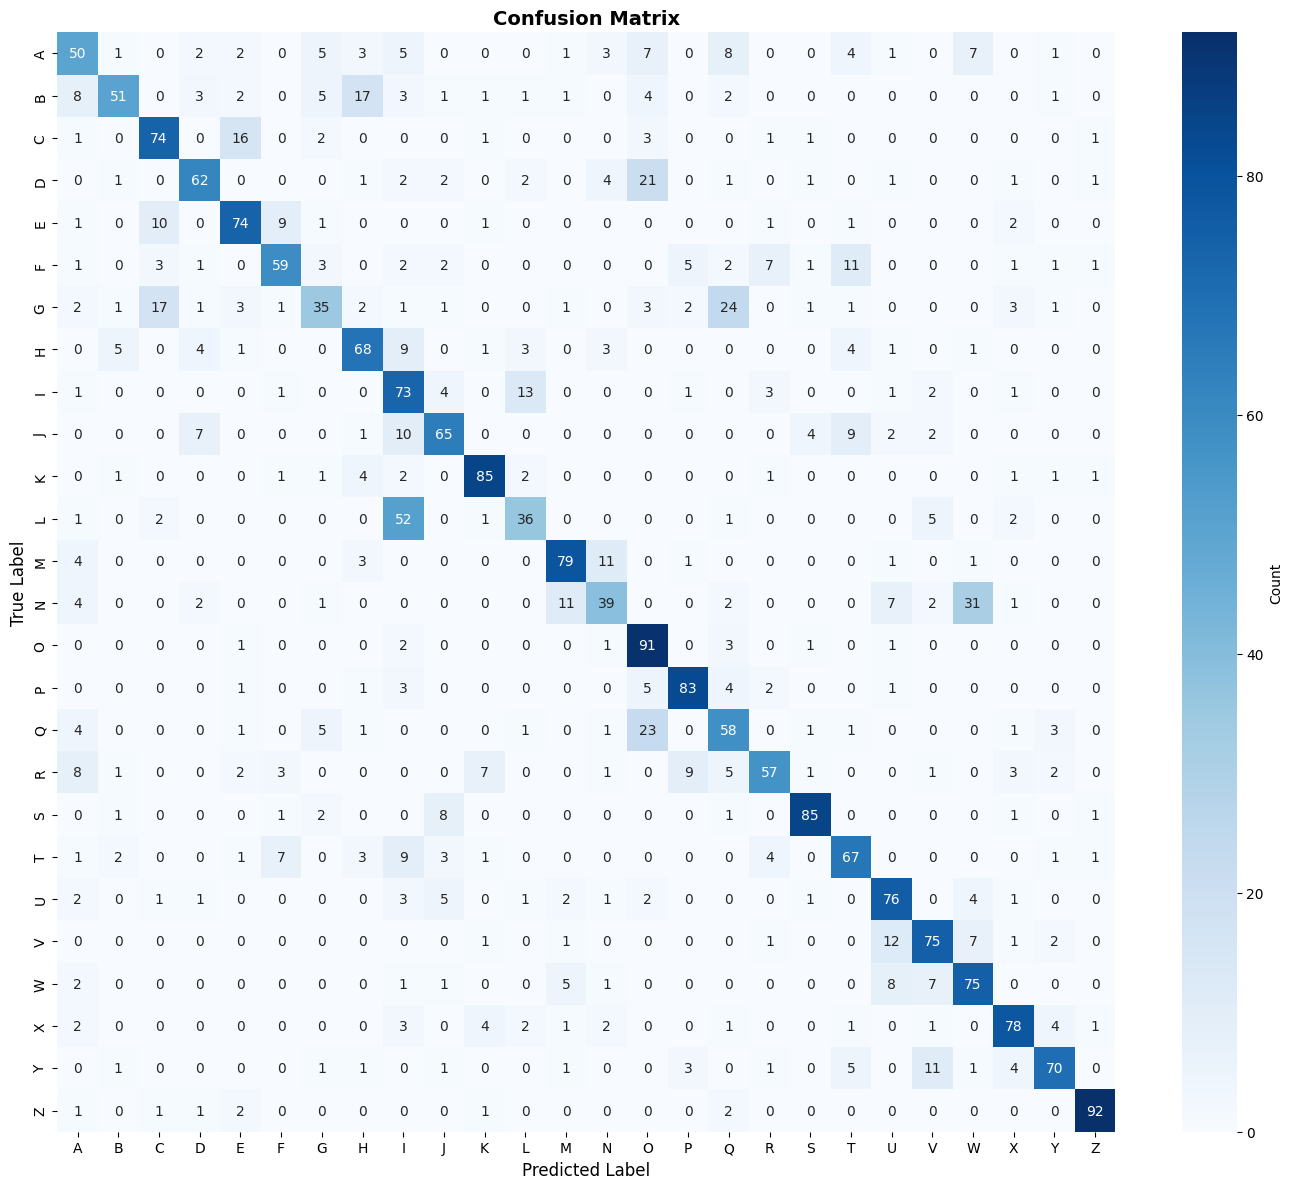

✓ Confusion matrix tersimpan: /content/drive/MyDrive/ATS_Irene_Tesalonika/outputs/confusion_matrix_loocv.png

✓ Semua hasil tersimpan di: /content/drive/MyDrive/ATS_Irene_Tesalonika/outputs


In [11]:
OUTPUT_DIR = Path("/content/drive/MyDrive/ATS_Irene_Tesalonika/outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Menyimpan hasil evaluasi...\n")

# Save overall metrics
results_metrics = {
    "accuracy": float(acc),
    "precision_macro": float(prec),
    "recall_macro": float(rec),
    "f1_macro": float(f1),
    "training_time_seconds": float(training_time),
    "cv_method": "LOOCV"
}
pd.DataFrame([results_metrics]).to_csv(OUTPUT_DIR / "metrics_loocv.csv", index=False)
print(f"✓ Metrik overall tersimpan: {OUTPUT_DIR / 'metrics_loocv.csv'}")

# Save per-class metrics
metrics_by_class = pd.DataFrame({
    'Class': labels_text,
    'Precision': prec_per_class,
    'Recall': rec_per_class,
    'F1_Score': f1_per_class
})
metrics_by_class.to_csv(OUTPUT_DIR / "metrics_per_class.csv", index=False)
print(f"✓ Metrik per kelas tersimpan: {OUTPUT_DIR / 'metrics_per_class.csv'}")

# Save confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, cmap="Blues", annot=True, fmt="d",
            xticklabels=labels_text, yticklabels=labels_text,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix_loocv.png", dpi=200, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix tersimpan: {OUTPUT_DIR / 'confusion_matrix_loocv.png'}")

print(f"\n✓ Semua hasil tersimpan di: {OUTPUT_DIR}")

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

print('Inisialisasi proses parameter tuning...')
DEV_SET_RATIO = 0.5
X_dev_set, _, y_dev_set, _ = train_test_split(
    hog_features, label_data, test_size=1-DEV_SET_RATIO, stratify=label_data, random_state=42)
print(f'Dataset untuk tuning: {len(y_dev_set)} sampel')

svm_param_grid = {
    'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

print('Eksekusi GridSearchCV untuk pencarian parameter optimal...')
grid_search = GridSearchCV(
    SVC(),
    svm_param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
grid_search.fit(X_dev_set, y_dev_set)

print('\nParameter tuning selesai dieksekusi.')
print(f'Kombinasi parameter terbaik: {grid_search.best_params_}')
print(f'Akurasi terbaik: {grid_search.best_score_:.4f}')

Inisialisasi proses parameter tuning...
Dataset untuk tuning: 6500 sampel
Eksekusi GridSearchCV untuk pencarian parameter optimal...
